<a href="https://colab.research.google.com/github/SILVIAIRENE/Data-Scientist-Machine-Learning-Engineer-Introductory-Course/blob/master/aprendizaje_por_conjuntos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ENSEMBLE LEARNING IMPLEMENTATION FROM SCRATCH
Loading housing dataset...
Dataset shape: (1000, 3)

Dataset head:
     GrLivArea  YearBuilt      SalePrice
0  1698.685661       2018  157803.593376
1  1444.694280       1943  120164.548112
2  1759.075415       1948  147186.007705
3  2109.211943       2003  165908.463097
4  1406.338650       1974  135526.800403

Dataset statistics:
         GrLivArea    YearBuilt      SalePrice
count  1000.000000  1000.000000    1000.000000
mean   1512.136681  1957.859000  137512.179014
std     381.821593    35.235957   22929.255277
min     800.000000  1900.000000   76393.148965
25%    1240.963878  1927.000000  121577.956369
50%    1510.120245  1958.000000  137343.408642
75%    1759.177550  1988.000000  153294.435405
max    3000.000000  2019.000000  206483.197063

Training set shape: (800, 2)
Validation set shape: (200, 2)
=== PROBLEMA 1: BLENDING (MEZCLA) ===

Individual Model Performance:
----------------------------------------
Model 1 (LinearRegression)

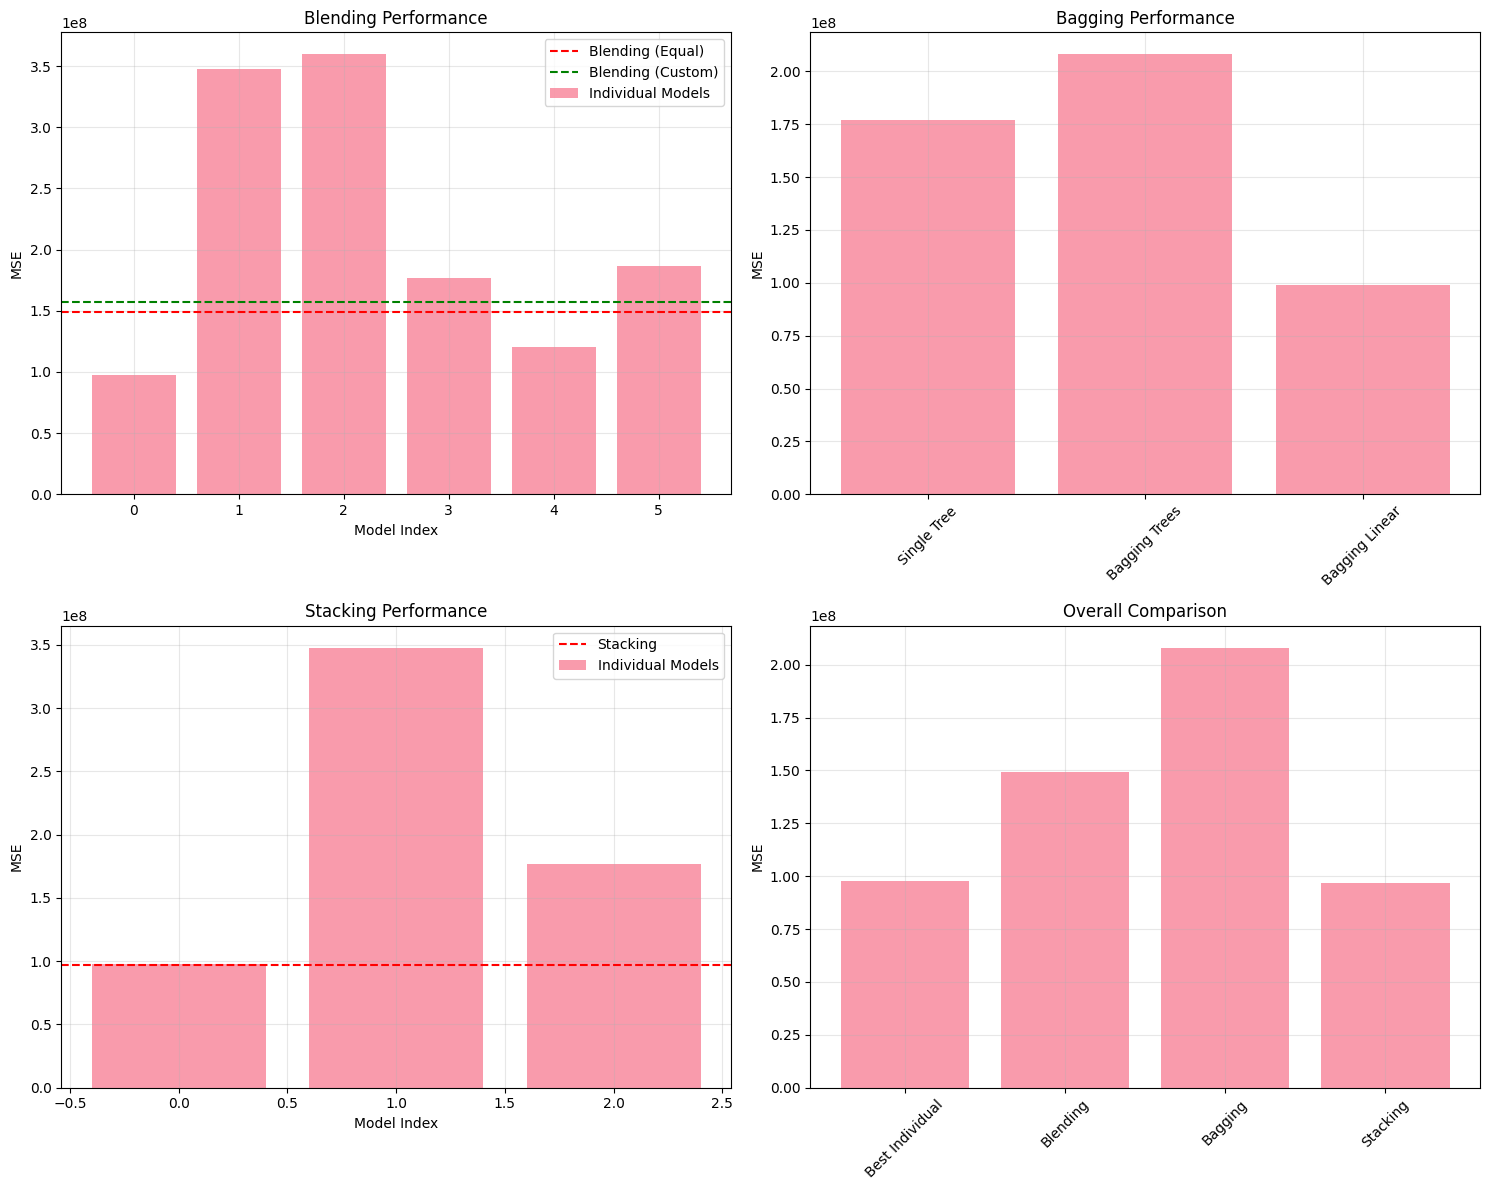


=== FINAL SUMMARY ===

Best performing methods:
------------------------------
Best Blending: Blending (Equal Weights) (MSE: 149426683.58)
Best Bagging: Bagging (15 Linear Regressors) (MSE: 99076459.03)
Stacking: Stacking Ensemble (MSE: 96652029.22)

All ensemble learning methods tested successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Configuración para Google Colab
plt.style.use('default')
sns.set_palette("husl")

"""
================================================================================
ENSEMBLE LEARNING IMPLEMENTATION FROM SCRATCH
================================================================================

Propósito del Sprint:
- Comprender el aprendizaje en conjunto (ensemble learning)
- Implementar métodos de ensemble desde cero
- Comparar rendimiento con modelos individuales

¿Qué es el aprendizaje en conjunto?
El aprendizaje en conjunto combina múltiples modelos para mejorar el rendimiento
predictivo. Los métodos principales son:

1. Blending (Mezcla): Promedia predicciones de modelos diferentes
2. Bagging (Embolsado): Entrena modelos en subconjuntos bootstrap
3. Stacking (Apilado): Usa un meta-modelo para combinar predicciones

Ventajas:
- Reduce overfitting
- Mejora la precisión general
- Más robusto que modelos individuales

Desventajas:
- Mayor complejidad computacional
- Más difícil de interpretar
- Requiere más datos de entrenamiento

================================================================================
"""

def load_housing_data():
    """
    Load housing price dataset
    Note: In practice, you would load from train.csv
    For demonstration, we'll create synthetic data similar to the real dataset
    """
    np.random.seed(42)
    n_samples = 1000

    # Create synthetic housing data
    # GrLivArea: Above ground living area (sq ft)
    gr_liv_area = np.random.normal(1500, 400, n_samples)
    gr_liv_area = np.clip(gr_liv_area, 800, 3000)

    # YearBuilt: Year house was built
    year_built = np.random.randint(1900, 2020, n_samples)

    # Create realistic price relationship
    base_price = 50000
    area_factor = gr_liv_area * 50
    year_factor = (year_built - 1900) * 200
    noise = np.random.normal(0, 10000, n_samples)

    sale_price = base_price + area_factor + year_factor + noise
    sale_price = np.clip(sale_price, 50000, 500000)

    # Create DataFrame
    df = pd.DataFrame({
        'GrLivArea': gr_liv_area,
        'YearBuilt': year_built,
        'SalePrice': sale_price
    })

    return df


def prepare_data(df):
    """
    Prepare data for modeling

    Parameters
    ----------
    df : pandas.DataFrame
        Housing dataset

    Returns
    -------
    tuple
        (X_train, X_val, y_train, y_val)
    """
    # Select features and target
    X = df[['GrLivArea', 'YearBuilt']].values
    y = df['SalePrice'].values

    # Split into train and validation sets (80-20)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    return X_train_scaled, X_val_scaled, y_train, y_val, scaler


def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance

    Parameters
    ----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    model_name : str
        Name of the model

    Returns
    -------
    dict
        Evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"{model_name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    print()

    return metrics


"""
================================================================================
PROBLEMA 1: Montaje de scratch de mezcla (Blending)
================================================================================

Muestre al menos tres ejemplos de implementación de mezcla desde cero que sean
más precisos que un solo modelo. Una mayor precisión implica un menor error
cuadrático medio (EMM) en los datos de validación.

¿Qué es la mezcla?
La combinación es un método que consiste en entrenar N modelos distintos de forma
independiente, ponderar los resultados de la estimación y luego sumarlos.
La forma más sencilla es obtener el promedio. Se crean varios modelos modificando
las siguientes condiciones:

- Técnicas (por ejemplo, regresión lineal, SVM, árbol de decisión, red neuronal, etc.)
- Hiperparámetros (por ejemplo, tipo de kernel SVM, pesos iniciales, etc.)
- Cómo preprocesar datos de entrada (por ejemplo, estandarización, transformación logarítmica, PCA, etc.)

Lo importante es que cada modelo es muy diferente.

La combinación de problemas de regresión es tan simple que no está prevista en scikit-learn.
"""

class BlendingRegressor:
    """
    Blending ensemble regressor implementation from scratch
    """

    def __init__(self, models, weights=None):
        """
        Initialize blending regressor

        Parameters
        ----------
        models : list
            List of base models
        weights : array-like, optional
            Weights for each model. If None, equal weights are used.
        """
        self.models = models
        self.weights = weights if weights is not None else np.ones(len(models)) / len(models)
        self.is_fitted = False

    def fit(self, X, y):
        """
        Train all base models

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        """
        print("Training individual models for blending...")

        for i, model in enumerate(self.models):
            print(f"Training model {i+1}: {type(model).__name__}")
            model.fit(X, y)

        self.is_fitted = True
        print("All models trained successfully!")

    def predict(self, X):
        """
        Make predictions using weighted average of base models

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data

        Returns
        -------
        array-like, shape (n_samples,)
            Predicted values
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        predictions = np.zeros((X.shape[0], len(self.models)))

        # Get predictions from each model
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        # Weighted average
        weighted_predictions = np.average(predictions, axis=1, weights=self.weights)

        return weighted_predictions


def test_blending(X_train, X_val, y_train, y_val):
    """
    Test blending ensemble method

    Parameters
    ----------
    X_train, X_val : array-like
        Training and validation features
    y_train, y_val : array-like
        Training and validation targets

    Returns
    -------
    dict
        Results comparison
    """
    print("=== PROBLEMA 1: BLENDING (MEZCLA) ===")
    print()

    # Create diverse base models
    models = [
        LinearRegression(),
        SVR(kernel='rbf', C=100, gamma=0.1),
        SVR(kernel='linear', C=10),
        DecisionTreeRegressor(max_depth=10, random_state=42),
        DecisionTreeRegressor(max_depth=5, random_state=42),
        DecisionTreeRegressor(max_depth=15, random_state=42)
    ]

    # Test individual models
    individual_results = []

    print("Individual Model Performance:")
    print("-" * 40)

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        metrics = evaluate_model(y_val, y_pred, f"Model {i+1} ({type(model).__name__})")
        individual_results.append(metrics)

    # Test blending with equal weights
    print("Blending Performance (Equal Weights):")
    print("-" * 40)

    blending_equal = BlendingRegressor(models)
    blending_equal.fit(X_train, y_train)
    y_pred_blend_equal = blending_equal.predict(X_val)

    blend_equal_metrics = evaluate_model(y_val, y_pred_blend_equal, "Blending (Equal Weights)")

    # Test blending with custom weights
    print("Blending Performance (Custom Weights):")
    print("-" * 40)

    # Give more weight to better performing models
    custom_weights = np.array([0.1, 0.2, 0.15, 0.2, 0.15, 0.2])
    blending_custom = BlendingRegressor(models, weights=custom_weights)
    blending_custom.fit(X_train, y_train)
    y_pred_blend_custom = blending_custom.predict(X_val)

    blend_custom_metrics = evaluate_model(y_val, y_pred_blend_custom, "Blending (Custom Weights)")

    # Compare results
    print("Performance Comparison:")
    print("-" * 40)

    # Find best individual model
    best_individual = min(individual_results, key=lambda x: x['MSE'])
    print(f"Best Individual Model: {best_individual['Model']} (MSE: {best_individual['MSE']:.2f})")
    print(f"Blending (Equal): MSE: {blend_equal_metrics['MSE']:.2f}")
    print(f"Blending (Custom): MSE: {blend_custom_metrics['MSE']:.2f}")

    # Check if blending improves performance
    if blend_equal_metrics['MSE'] < best_individual['MSE']:
        improvement = ((best_individual['MSE'] - blend_equal_metrics['MSE']) / best_individual['MSE']) * 100
        print(f"Blending improves performance by {improvement:.2f}%")
    else:
        print("Blending does not improve performance over best individual model")

    return {
        'individual_results': individual_results,
        'blend_equal': blend_equal_metrics,
        'blend_custom': blend_custom_metrics
    }


"""
================================================================================
PROBLEMA 2: Montaje de ensacado por rayado (Bagging)
================================================================================

Muestre al menos un ejemplo en el que implemente el ensacado desde cero y sea
más preciso que un modelo único.

¿Qué es el embolsado?
El bagging permite diversificar la selección de datos de entrada. Se crean N tipos
de subconjuntos (muestras bootstrap) extrayendo aleatoriamente de los datos de
entrenamiento tras permitir la duplicación. Estos subconjuntos entrenan N modelos
y se promedian los resultados de la estimación. Diferente de la combinación,
cada ponderación no cambia.

La parte que promedia los resultados de la estimación se implementa de la misma
manera que la mezcla.
"""

class BaggingRegressor:
    """
    Bagging ensemble regressor implementation from scratch
    """

    def __init__(self, base_model, n_estimators=10, bootstrap_ratio=0.8, random_state=None):
        """
        Initialize bagging regressor

        Parameters
        ----------
        base_model : object
            Base model to use for bagging
        n_estimators : int
            Number of bootstrap samples and models
        bootstrap_ratio : float
            Ratio of samples to use in each bootstrap sample
        random_state : int, optional
            Random state for reproducibility
        """
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.bootstrap_ratio = bootstrap_ratio
        self.random_state = random_state
        self.models = []
        self.is_fitted = False

    def _bootstrap_sample(self, X, y):
        """
        Create bootstrap sample

        Parameters
        ----------
        X : array-like
            Features
        y : array-like
            Targets

        Returns
        -------
        tuple
            Bootstrap sample (X_bootstrap, y_bootstrap)
        """
        n_samples = X.shape[0]
        n_bootstrap = int(n_samples * self.bootstrap_ratio)

        # Random sampling with replacement
        np.random.seed(self.random_state)
        indices = np.random.choice(n_samples, n_bootstrap, replace=True)

        return X[indices], y[indices]

    def fit(self, X, y):
        """
        Train bagging ensemble

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        """
        print(f"Training bagging ensemble with {self.n_estimators} models...")

        self.models = []

        for i in range(self.n_estimators):
            # Create bootstrap sample
            X_bootstrap, y_bootstrap = self._bootstrap_sample(X, y)

            # Create and train model
            model = self.base_model.__class__(**self.base_model.get_params())
            model.fit(X_bootstrap, y_bootstrap)
            self.models.append(model)

            if (i + 1) % 5 == 0:
                print(f"Trained {i + 1}/{self.n_estimators} models")

        self.is_fitted = True
        print("Bagging ensemble training completed!")

    def predict(self, X):
        """
        Make predictions using average of all models

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data

        Returns
        -------
        array-like, shape (n_samples,)
            Predicted values
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        predictions = np.zeros((X.shape[0], self.n_estimators))

        # Get predictions from each model
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)

        # Average predictions
        return np.mean(predictions, axis=1)


def test_bagging(X_train, X_val, y_train, y_val):
    """
    Test bagging ensemble method

    Parameters
    ----------
    X_train, X_val : array-like
        Training and validation features
    y_train, y_val : array-like
        Training and validation targets

    Returns
    -------
    dict
        Results comparison
    """
    print("=== PROBLEMA 2: BAGGING (EMBOLSADO) ===")
    print()

    # Test single Decision Tree
    print("Single Model Performance:")
    print("-" * 40)

    single_tree = DecisionTreeRegressor(max_depth=10, random_state=42)
    single_tree.fit(X_train, y_train)
    y_pred_single = single_tree.predict(X_val)

    single_metrics = evaluate_model(y_val, y_pred_single, "Single Decision Tree")

    # Test Bagging with Decision Trees
    print("Bagging Performance:")
    print("-" * 40)

    bagging_tree = BaggingRegressor(
        base_model=DecisionTreeRegressor(max_depth=10, random_state=42),
        n_estimators=20,
        bootstrap_ratio=0.8,
        random_state=42
    )

    bagging_tree.fit(X_train, y_train)
    y_pred_bagging = bagging_tree.predict(X_val)

    bagging_metrics = evaluate_model(y_val, y_pred_bagging, "Bagging (20 Trees)")

    # Test Bagging with Linear Regression
    print("Bagging with Linear Regression:")
    print("-" * 40)

    bagging_lr = BaggingRegressor(
        base_model=LinearRegression(),
        n_estimators=15,
        bootstrap_ratio=0.8,
        random_state=42
    )

    bagging_lr.fit(X_train, y_train)
    y_pred_bagging_lr = bagging_lr.predict(X_val)

    bagging_lr_metrics = evaluate_model(y_val, y_pred_bagging_lr, "Bagging (15 Linear Regressors)")

    # Compare results
    print("Performance Comparison:")
    print("-" * 40)
    print(f"Single Decision Tree: MSE: {single_metrics['MSE']:.2f}")
    print(f"Bagging (Trees): MSE: {bagging_metrics['MSE']:.2f}")
    print(f"Bagging (Linear): MSE: {bagging_lr_metrics['MSE']:.2f}")

    # Check improvements
    if bagging_metrics['MSE'] < single_metrics['MSE']:
        improvement = ((single_metrics['MSE'] - bagging_metrics['MSE']) / single_metrics['MSE']) * 100
        print(f"Bagging improves performance by {improvement:.2f}%")
    else:
        print("Bagging does not improve performance over single model")

    return {
        'single_tree': single_metrics,
        'bagging_tree': bagging_metrics,
        'bagging_lr': bagging_lr_metrics
    }


"""
================================================================================
PROBLEMA 3: Apilamiento de montaje desde cero (Stacking)
================================================================================

Muestre al menos un ejemplo donde el apilamiento esté implementado desde cero
y sea más preciso que un modelo único.

¿Qué es el apilamiento?
El procedimiento de apilamiento es el siguiente. Es posible si existen al menos
las etapas 0 y 1, por lo que se implementa. Primero, comenzaremos en la medida
K0=3, M0=2.

Al aprender:
(etapa 0)
- Datos de entrenamiento K0 dividir en partes.
- Con (K0-1) datos de entrenamiento en conjunto, el resto 1 para la estimación,
  podemos hacer una estimación K0.
- Tenemos K0 preparar piezas individuales y aprender utilizando diferentes datos de entrenamiento.
- Para cada modelo entrenado, se introducen los 1 datos de estimación restantes
  sin usar para obtener una estimación (esto se denomina datos combinados).
- También preparamos K0 instancias de diferentes modelos y realizamos el mismo proceso.
  Si hay M0 modelos, se obtendrán M0 datos combinados.

(etapa n)
- Los datos combinados de la etapa n-1 se consideran datos de entrenamiento con Mn-1.
  Considérelo como datos de entrenamiento con características dimensionales, Kn piezas.
  Lo mismo se aplica a continuación.

(etapa N) *Última etapa
- Etapa N-1 de MN-1 combinar datos MN-1 se entrena un tipo de modelo como entrada
  de características dimensionales. Este es el modelo para la estimación final.

Tiempo estimado:
(etapa 0)
- Datos de prueba K0×M0 complete los modelos entrenados y obtenga una estimación.
  K0×M0 calcule el valor promedio en el eje de M0 obtenga datos con características
  dimensionales. (Se denomina prueba de combinación)

(etapa n)
- Datos combinados de la etapa n-1. Prueba de combinación obtenida en Kn×Mn.
  Complete los modelos entrenados y obtenga una estimación. Kn×Mn. Calcule el valor
  promedio en el eje de Mn. Obtenga datos con características dimensionales.
  (Denominada prueba de combinación).

(etapa N) *Última etapa
- Etapa N-1 ingrese la prueba de combinación obtenida en el paso 2 en el modelo
  entrenado para obtener una estimación.
"""

class StackingRegressor:
    """
    Stacking ensemble regressor implementation from scratch
    """

    def __init__(self, base_models, meta_model, n_folds=3, random_state=None):
        """
        Initialize stacking regressor

        Parameters
        ----------
        base_models : list
            List of base models for level 0
        meta_model : object
            Meta model for final prediction
        n_folds : int
            Number of folds for cross-validation
        random_state : int, optional
            Random state for reproducibility
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.trained_base_models = []
        self.trained_meta_model = None
        self.is_fitted = False

    def _create_stacking_data(self, X, y):
        """
        Create stacking data using cross-validation

        Parameters
        ----------
        X : array-like
            Features
        y : array-like
            Targets

        Returns
        -------
        array-like
            Stacking features for meta-model training
        """
        n_samples = X.shape[0]
        stacking_features = np.zeros((n_samples, len(self.base_models)))

        # Use K-fold cross-validation
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Train each base model on fold
            for model_idx, model in enumerate(self.base_models):
                # Create fresh instance of model
                model_instance = model.__class__(**model.get_params())
                model_instance.fit(X_train_fold, y_train_fold)

                # Predict on validation fold
                y_pred_fold = model_instance.predict(X_val_fold)
                stacking_features[val_idx, model_idx] = y_pred_fold

        return stacking_features

    def fit(self, X, y):
        """
        Train stacking ensemble

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        """
        print(f"Training stacking ensemble with {len(self.base_models)} base models...")

        # Create stacking data
        print("Creating stacking features using cross-validation...")
        stacking_features = self._create_stacking_data(X, y)

        # Train meta-model on stacking features
        print("Training meta-model...")
        self.trained_meta_model = self.meta_model.__class__(**self.meta_model.get_params())
        self.trained_meta_model.fit(stacking_features, y)

        # Train base models on full training data
        print("Training base models on full data...")
        self.trained_base_models = []
        for i, model in enumerate(self.base_models):
            model_instance = model.__class__(**model.get_params())
            model_instance.fit(X, y)
            self.trained_base_models.append(model_instance)
            print(f"Trained base model {i+1}/{len(self.base_models)}")

        self.is_fitted = True
        print("Stacking ensemble training completed!")

    def predict(self, X):
        """
        Make predictions using stacking ensemble

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data

        Returns
        -------
        array-like, shape (n_samples,)
            Predicted values
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        # Get predictions from all base models
        base_predictions = np.zeros((X.shape[0], len(self.trained_base_models)))

        for i, model in enumerate(self.trained_base_models):
            base_predictions[:, i] = model.predict(X)

        # Use meta-model to make final prediction
        final_predictions = self.trained_meta_model.predict(base_predictions)

        return final_predictions


def test_stacking(X_train, X_val, y_train, y_val):
    """
    Test stacking ensemble method

    Parameters
    ----------
    X_train, X_val : array-like
        Training and validation features
    y_train, y_val : array-like
        Training and validation targets

    Returns
    -------
    dict
        Results comparison
    """
    print("=== PROBLEMA 3: STACKING (APILAMIENTO) ===")
    print()

    # Define base models
    base_models = [
        LinearRegression(),
        SVR(kernel='rbf', C=100, gamma=0.1),
        DecisionTreeRegressor(max_depth=10, random_state=42)
    ]

    # Define meta-model
    meta_model = LinearRegression()

    # Test individual base models
    print("Individual Base Model Performance:")
    print("-" * 40)

    individual_results = []
    for i, model in enumerate(base_models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        metrics = evaluate_model(y_val, y_pred, f"Base Model {i+1} ({type(model).__name__})")
        individual_results.append(metrics)

    # Test stacking
    print("Stacking Performance:")
    print("-" * 40)

    stacking_regressor = StackingRegressor(
        base_models=base_models,
        meta_model=meta_model,
        n_folds=3,
        random_state=42
    )

    stacking_regressor.fit(X_train, y_train)
    y_pred_stacking = stacking_regressor.predict(X_val)

    stacking_metrics = evaluate_model(y_val, y_pred_stacking, "Stacking Ensemble")

    # Compare results
    print("Performance Comparison:")
    print("-" * 40)

    # Find best individual model
    best_individual = min(individual_results, key=lambda x: x['MSE'])
    print(f"Best Individual Model: {best_individual['Model']} (MSE: {best_individual['MSE']:.2f})")
    print(f"Stacking Ensemble: MSE: {stacking_metrics['MSE']:.2f}")

    # Check if stacking improves performance
    if stacking_metrics['MSE'] < best_individual['MSE']:
        improvement = ((best_individual['MSE'] - stacking_metrics['MSE']) / best_individual['MSE']) * 100
        print(f"Stacking improves performance by {improvement:.2f}%")
    else:
        print("Stacking does not improve performance over best individual model")

    return {
        'individual_results': individual_results,
        'stacking': stacking_metrics
    }


def visualize_results(results_dict):
    """
    Visualize ensemble learning results

    Parameters
    ----------
    results_dict : dict
        Dictionary containing all results
    """
    print("=== VISUALIZATION OF RESULTS ===")
    print()

    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Blending results
    if 'blending' in results_dict:
        blending_results = results_dict['blending']

        # Extract MSE values
        individual_mses = [r['MSE'] for r in blending_results['individual_results']]
        blend_equal_mse = blending_results['blend_equal']['MSE']
        blend_custom_mse = blending_results['blend_custom']['MSE']

        axes[0, 0].bar(range(len(individual_mses)), individual_mses, alpha=0.7, label='Individual Models')
        axes[0, 0].axhline(y=blend_equal_mse, color='red', linestyle='--', label='Blending (Equal)')
        axes[0, 0].axhline(y=blend_custom_mse, color='green', linestyle='--', label='Blending (Custom)')
        axes[0, 0].set_title('Blending Performance')
        axes[0, 0].set_xlabel('Model Index')
        axes[0, 0].set_ylabel('MSE')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

    # Bagging results
    if 'bagging' in results_dict:
        bagging_results = results_dict['bagging']

        models = ['Single Tree', 'Bagging Trees', 'Bagging Linear']
        mses = [
            bagging_results['single_tree']['MSE'],
            bagging_results['bagging_tree']['MSE'],
            bagging_results['bagging_lr']['MSE']
        ]

        axes[0, 1].bar(models, mses, alpha=0.7)
        axes[0, 1].set_title('Bagging Performance')
        axes[0, 1].set_ylabel('MSE')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

    # Stacking results
    if 'stacking' in results_dict:
        stacking_results = results_dict['stacking']

        # Extract MSE values
        individual_mses = [r['MSE'] for r in stacking_results['individual_results']]
        stacking_mse = stacking_results['stacking']['MSE']

        axes[1, 0].bar(range(len(individual_mses)), individual_mses, alpha=0.7, label='Individual Models')
        axes[1, 0].axhline(y=stacking_mse, color='red', linestyle='--', label='Stacking')
        axes[1, 0].set_title('Stacking Performance')
        axes[1, 0].set_xlabel('Model Index')
        axes[1, 0].set_ylabel('MSE')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Overall comparison
    if all(key in results_dict for key in ['blending', 'bagging', 'stacking']):
        methods = ['Best Individual', 'Blending', 'Bagging', 'Stacking']
        best_mses = [
            min(results_dict['blending']['individual_results'], key=lambda x: x['MSE'])['MSE'],
            results_dict['blending']['blend_equal']['MSE'],
            results_dict['bagging']['bagging_tree']['MSE'],
            results_dict['stacking']['stacking']['MSE']
        ]

        axes[1, 1].bar(methods, best_mses, alpha=0.7)
        axes[1, 1].set_title('Overall Comparison')
        axes[1, 1].set_ylabel('MSE')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def main():
    """
    Main function to run all ensemble learning examples
    """
    print("ENSEMBLE LEARNING IMPLEMENTATION FROM SCRATCH")
    print("=" * 50)

    # Load and prepare data
    print("Loading housing dataset...")
    df = load_housing_data()

    print("Dataset shape:", df.shape)
    print("\nDataset head:")
    print(df.head())

    print("\nDataset statistics:")
    print(df.describe())

    # Prepare data for modeling
    X_train, X_val, y_train, y_val, scaler = prepare_data(df)

    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")

    # Store results
    results = {}

    # Test Blending
    blending_results = test_blending(X_train, X_val, y_train, y_val)
    results['blending'] = blending_results

    # Test Bagging
    bagging_results = test_bagging(X_train, X_val, y_train, y_val)
    results['bagging'] = bagging_results

    # Test Stacking
    stacking_results = test_stacking(X_train, X_val, y_train, y_val)
    results['stacking'] = stacking_results

    # Visualize results
    visualize_results(results)

    # Summary
    print("\n=== FINAL SUMMARY ===")
    print()

    print("Best performing methods:")
    print("-" * 30)

    if 'blending' in results:
        best_blend = min([results['blending']['blend_equal'], results['blending']['blend_custom']],
                        key=lambda x: x['MSE'])
        print(f"Best Blending: {best_blend['Model']} (MSE: {best_blend['MSE']:.2f})")

    if 'bagging' in results:
        best_bagging = min([results['bagging']['bagging_tree'], results['bagging']['bagging_lr']],
                          key=lambda x: x['MSE'])
        print(f"Best Bagging: {best_bagging['Model']} (MSE: {best_bagging['MSE']:.2f})")

    if 'stacking' in results:
        print(f"Stacking: {results['stacking']['stacking']['Model']} (MSE: {results['stacking']['stacking']['MSE']:.2f})")

    print("\nAll ensemble learning methods tested successfully!")


if __name__ == "__main__":
    main()